# Import modules

In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
from tensorflow.keras import backend as B
from tensorflow.keras import backend, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GaussianNoise, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

import matplotlib.pyplot as plt
%matplotlib inline

from vit_keras import vit
from ipynb.fs.full.utils import *

# Variables Initialization and Data Description

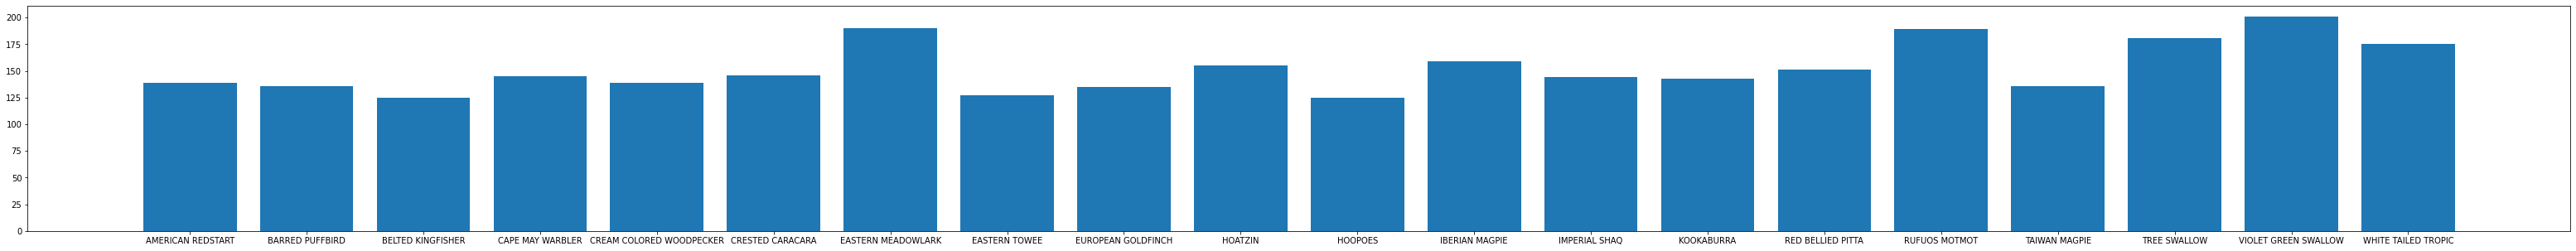

In [2]:
train_path = './dataset/20train'
test_path = './dataset/20test'
valid_path = './dataset/20valid'
nr_birds = 20

describe_data();

# Prepare Generators

Found 3041 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


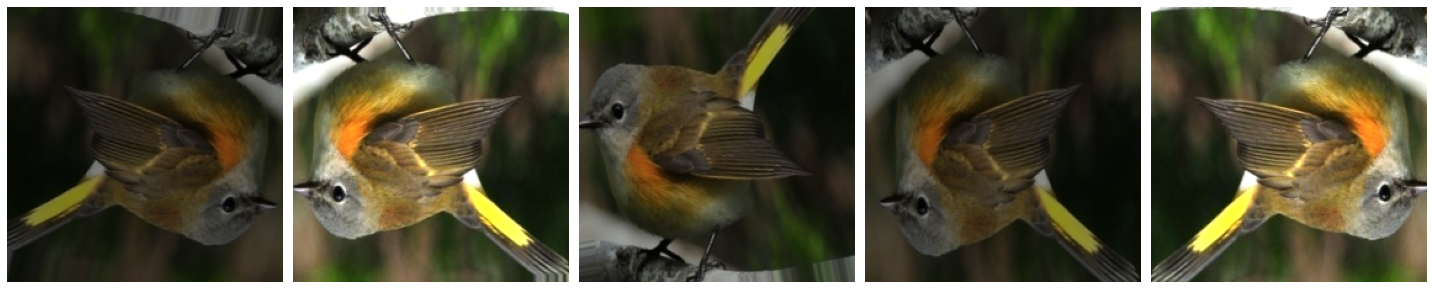

In [3]:
# Data augmentation
train_datagen = ImageDataGenerator(
  rescale=1/255,
  horizontal_flip=True,
  vertical_flip=True,
  rotation_range=15,
  zoom_range=0.1,
  brightness_range=[0.5, 1.5],
)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
  train_path,
  target_size=(224, 224),
  batch_size=64,
  color_mode='rgb',
  class_mode='categorical',
  shuffle=True,
)

validation_generator = valid_datagen.flow_from_directory(
  valid_path,
  target_size=(224, 224),
  batch_size=32,
  color_mode='rgb',
  class_mode='categorical',
  shuffle=False,
)

test_generator = test_datagen.flow_from_directory(
  test_path,
  target_size=(224, 224),
  batch_size=32,
  color_mode='rgb',
  class_mode='categorical',
  shuffle=False
)


def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Declare Schedulers

In [4]:
# Decay lr for each 7 epochs
def scheduler(epoch: int, lr: float) -> float:
  if epoch != 0 and epoch % 7 == 0:
    return lr * 0.1
  else:
    return lr
lr_scheduler_callback = LearningRateScheduler(scheduler)

def lr_scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(1.5)

class EarlyStoppingByLossVal(Callback):
  def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
    super(Callback, self).__init__()
    self.monitor = monitor
    self.value = value
    self.verbose = verbose
      

  def on_epoch_end(self, epoch, logs={}):
    current = logs.get(self.monitor)
    if current is None:
        warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

    if current < self.value:
        if self.verbose > 0:
            print("Epoch %05d: early stopping THR" % epoch)
        self.model.stop_training = True

# Load pre-trained Model, Build model and Train model

In [5]:
backend.clear_session()

finetune_at = 28

vit_model = vit.vit_l32(
  image_size=224,
  pretrained=True,
  include_top=False,
  pretrained_top=False
)

# fine-tuning
for layer in vit_model.layers[:finetune_at - 1]:
  layer.trainable = False
    
num_classes = len(validation_generator.class_indices)

# Add GaussianNoise layer for robustness
noise = GaussianNoise(0.01, input_shape=(224, 224, 3))
# dropout = Dropout(0.2)
head = Dense(num_classes, activation="softmax")
model = Sequential()
model.add(noise)
model.add(vit_model)
# model.add(dropout)
model.add(head)

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

AdamHistory = model.fit_generator(
          train_generator,
          epochs=10,
          validation_data=validation_generator,
          verbose=1,
          callbacks=[
              EarlyStoppingByLossVal(monitor='loss', value=0.01, verbose=1),
              lr_scheduler_callback
          ])

B.clear_session()

model.compile(optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
SgdHistory = model.fit_generator(
          train_generator,
          epochs=10,
          validation_data=validation_generator,
          verbose=1,
          callbacks=[
              EarlyStoppingByLossVal(monitor='loss', value=0.01, verbose=1),
              lr_scheduler_callback
          ])

2022-05-09 20:51:14.348639: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-09 20:51:14.348750: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



/Users/shaun/miniforge3/lib/python3.9/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(
/var/folders/x0/f6tjyw_s7vqbx5gcpvt0z31w0000gn/T/ipykernel_14245/2252879911.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  AdamHistory = model.fit_generator(


Epoch 1/10


2022-05-09 20:51:20.309513: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-09 20:51:30.911570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 0.5312 - accuracy: 0.8517

2022-05-09 20:57:07.906231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 363s 7s/step - loss: 0.5312 - accuracy: 0.8517 - val_loss: 0.0216 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 2/10
48/48 [==============================] - 343s 7s/step - loss: 0.1303 - accuracy: 0.9622 - val_loss: 0.0090 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
48/48 [==============================] - 324s 7s/step - loss: 0.0768 - accuracy: 0.9763 - val_loss: 0.0741 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 4/10
48/48 [==============================] - 305s 6s/step - loss: 0.0672 - accuracy: 0.9799 - val_loss: 0.0351 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 5/10
48/48 [==============================] - 306s 6s/step - loss: 0.0494 - accuracy: 0.9849 - val_loss: 0.0533 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 6/10
48/48 [==============================] - 311s 6s/step - loss: 0.0466 - accuracy: 0.9842 - val_loss: 0.0236 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 7/10
48/48 [==============================] - 316s 7s/step - loss: 0.0442 - accur

/Users/shaun/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/var/folders/x0/f6tjyw_s7vqbx5gcpvt0z31w0000gn/T/ipykernel_14245/2252879911.py:43: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  SgdHistory = model.fit_generator(


Epoch 1/10


2022-05-09 21:45:16.701586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9967

2022-05-09 21:50:34.785469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 344s 7s/step - loss: 0.0107 - accuracy: 0.9967 - val_loss: 0.0506 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 2/10
48/48 [==============================] - 318s 7s/step - loss: 0.0126 - accuracy: 0.9974 - val_loss: 0.0502 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 3/10
48/48 [==============================] - 306s 6s/step - loss: 0.0129 - accuracy: 0.9951 - val_loss: 0.0506 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 4/10
48/48 [==============================] - 312s 7s/step - loss: 0.0137 - accuracy: 0.9954 - val_loss: 0.0508 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 5/10
48/48 [==============================] - 310s 6s/step - loss: 0.0137 - accuracy: 0.9951 - val_loss: 0.0512 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 6/10
48/48 [==============================] - 316s 7s/step - loss: 0.0185 - accuracy: 0.9954 - val_loss: 0.0517 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 7/10
48/48 [==============================] - 318s 7s/step - loss: 0.0144 - accur

In [6]:
def plotLR(history):
  learning_rate = history.history['lr']
  epochs = range(1, len(learning_rate) + 1)
  fig = plt.figure(facecolor='white')
  plt.plot(learning_rate[:40], history.history['val_loss'][:40])
  plt.title('Relationship between loss and learning rate')
  plt.xlabel('Learning Rate')
  plt.ylabel('Validation Loss')
  return(fig)
  
# fig = plotLR(SgdHistory)
# fig.show()

/var/folders/x0/f6tjyw_s7vqbx5gcpvt0z31w0000gn/T/ipykernel_14245/2064230690.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


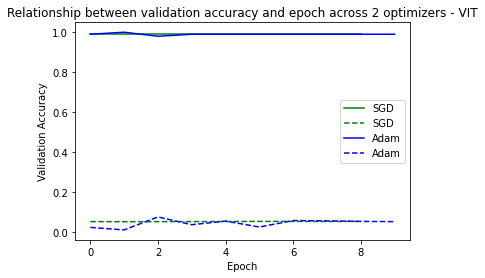

In [7]:
def plotOptimizer():
  fig = plt.figure(facecolor='white')
  plt.plot(SgdHistory.history['val_accuracy'], 'g', label='SGD')
  plt.plot(SgdHistory.history['val_loss'], 'g',  linestyle = 'dashed', label = 'SGD')
  plt.plot(AdamHistory.history['val_accuracy'], 'b', label='Adam')
  plt.plot(AdamHistory.history['val_loss'], 'b',  linestyle = 'dashed', label='Adam')
  
  plt.title('Relationship between validation accuracy and epoch across 2 optimizers - VIT')
  plt.xlabel('Epoch')
  plt.ylabel('Validation Accuracy')
  plt.legend()
  return fig

fig = plotOptimizer()
fig.show()

In [8]:
def plot_loss_acc(history, label):
  history_dict = history.history
  loss_values = history_dict["loss"]
  val_loss_values = history_dict["val_loss"]
  acc_values = history_dict["accuracy"]
  val_acc_values = history_dict["val_accuracy"]
  epochs = range(1, len(history_dict["accuracy"]) + 1)

  plt.figure(facecolor="w")
  plt.plot(epochs, loss_values, "b",marker="o", label="train")
  plt.plot(epochs, val_loss_values, "b", label="valid")
  plt.title("Loss - " + label)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  plt.figure(facecolor="w")
  plt.plot(epochs, acc_values, "b", marker="o", label="train")
  plt.plot(epochs, val_acc_values, "b", label="valid")
  plt.title("Accuracy - " + label)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  import numpy as np
  print("best val_acc:", np.max(val_acc_values), "epoch:", np.argmax(val_acc_values))
  print("best val_loss:", np.min(val_loss_values), "epoch:", np.argmin(val_loss_values))

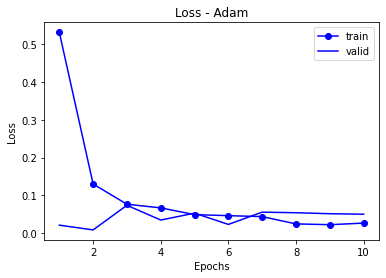

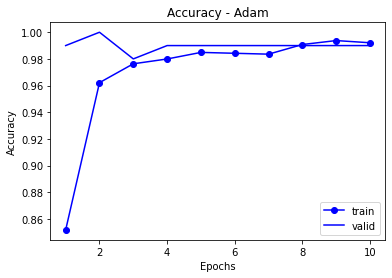

best val_acc: 1.0 epoch: 1
best val_loss: 0.009009567089378834 epoch: 1


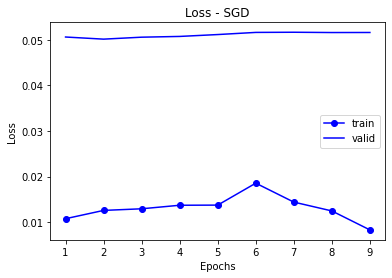

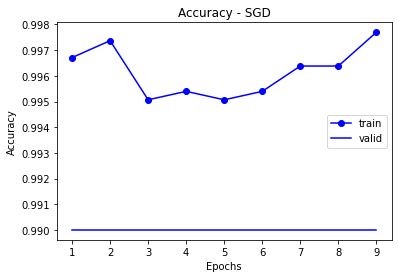

best val_acc: 0.9899999499320984 epoch: 0
best val_loss: 0.05018283799290657 epoch: 1


In [9]:
plot_loss_acc(AdamHistory, "Adam")
plot_loss_acc(SgdHistory, "SGD")

# Saving Model

In [10]:
model.save("./models/vit_l32_finetuned.h5")

## Running Predictions From Saved Model

In [11]:
def decode (predicted_arr):
  train_path = './dataset/20train'

  all_birds_cat = np.array(list(sorted(os.listdir(train_path))))
  for i, pred in enumerate(predicted_arr):
    confidence = np.round(np.max(pred) * 100, 2)
    return (all_birds_cat[np.argmax(pred)], confidence)

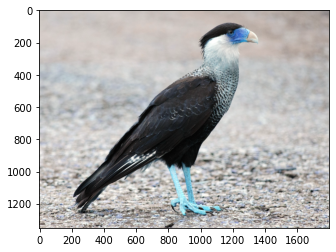

2022-05-09 22:32:55.173058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CRESTED CARACARA with 100.0% confidence


In [12]:
import tensorflow as tf
model = tf.keras.models.load_model('./models/vit_l32_finetuned.h5')

predict_image_path = './dataset/images to test/20.jpg'

plt.imshow(cv2.imread(predict_image_path))
plt.show();

img = load_img(predict_image_path, target_size=(224,224))
img = img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = vit.preprocess_inputs(img)

predictions = model.predict(img)
label, confidence = decode(predictions)

print(label + ' with ' + str(confidence) + '% confidence')